In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataset_utils
from Utils import MAPE, RMSELoss, EarlyStopper, global_seed, MyTimeSeriesSplitter, TestFixedSplitter
from Utils import write_table, pack_results
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score
import itertools
from collections import defaultdict
# from sklearn.compose import TransformedTargetRegressor
# from datetime import datetime
import pickle
import gan_model 

/home/grinenko/anaconda3/envs/anna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
soft = ['35_21_1000.Q.KatKlD.1444.octanI', '35_21_1000.Q.KatKlAB.DavNpar', '35_21_1000.Q.KatKlAB.EBen70', '35_21_1000.Q.KatKlAB.AroPf.v']
short_name = {'35_21_1000.Q.KatKlD.1444.octanI': 'octanI', 
              '35_21_1000.Q.KatKlAB.DavNpar' : 'DavNpar', 
              '35_21_1000.Q.KatKlAB.EBen70': 'Eben70', 
              '35_21_1000.Q.KatKlAB.AroPf.v' : 'AroPfv'
}

**Параметры**

In [4]:
K = 60 #усреднение
W=5
SOFT_SENSOR_INDEX = 2
SOFT_SENSOR_NAME = soft[SOFT_SENSOR_INDEX]
MODEL_PATH = f"./models/{short_name[SOFT_SENSOR_NAME]}.pth"
PERIODS_FILE = f"periods_W20_gr{K}_Agl.npy"

**Загрузка и подготовка данных**

In [5]:
data = pd.read_csv("Dataset1_nans.csv", sep=";")

In [6]:
data.head()

,Timestamp,35_21_1000.Q.KatKlAB.AroPf.v,35_21_1000.Q.KatKlAB.DavNpar,35_21_1000.Q.KatKlAB.EBen70,35_21_1000.Q.KatKlD.1444.octanI,35_21_1000_FC_3122,35_21_1000_FC_321.SP,35_21_1000_FI_3101,35_21_1000_FI_3130,35_21_1000_FI_326,...,35_21_1000_TI_3305,35_21_1000_TI_3581,CCR_CCR300_CV_3DT_H1_VAL,CCR_CCR300_CV_DT_R12_VAL,CCR_CCR300_CV_DT_R23_VAL,CCR_CCR300_CV_DT_R34_VAL,CCR_CCR300_CV_DT_R41_VAL,CCR_CCR300_CV_FI_3101PTC_VAL,CCR_CCR300_CV_PC_3180_OP_VAL,CCR_CCR300_CV_WAIT_SP_VAL
0,01.01.2016 00:00:00,65.59,48.0,6.0,98.9,33.61328,194.0002,59.90619,2798.065,50.50889,...,134.7649,25.61035,90.86990,-3.72980,-7.13281,-1.0,11.86261,59.14596,70.77777,519.1353
1,01.01.2016 00:01:00,NaN,NaN,NaN,NaN,33.77030,194.0002,60.26051,2826.544,50.86543,...,134.8389,25.61035,90.90942,-3.72989,-7.13306,-1.0,11.86295,59.18106,70.93322,519.1353
2,01.01.2016 00:02:00,NaN,NaN,NaN,NaN,33.86683,194.0002,60.16202,2817.218,50.76682,...,134.6192,25.61055,90.88013,-3.73050,-7.13440,-1.0,11.86490,59.16980,70.03181,519.1346
3,01.01.2016 00:03:00,NaN,NaN,NaN,NaN,34.00380,194.0002,60.28071,2806.594,50.84354,...,134.6191,25.63477,90.87057,-3.73145,-7.13660,-1.0,11.86804,59.30387,70.46443,519.1337
4,01.01.2016 00:04:00,NaN,NaN,NaN,NaN,33.70545,194.0002,59.33250,2774.242,50.95883,...,134.6191,25.63477,90.90518,-3.73212,-7.13818,-1.0,11.87030,59.26101,69.81942,519.1330


In [7]:
soft_data = data[soft].copy()
data_orig = data.drop(soft + ['Timestamp'], axis=1)

In [8]:
soft_data.shape

(2040480, 4)

In [9]:
data_orig.head()

,35_21_1000_FC_3122,35_21_1000_FC_321.SP,35_21_1000_FI_3101,35_21_1000_FI_3130,35_21_1000_FI_326,35_21_1000_LC_208.OP,35_21_1000_LC_3116.OP,35_21_1000_PC_1214,35_21_1000_PC_3123,35_21_1000_PC_3123.OP,...,35_21_1000_TI_3305,35_21_1000_TI_3581,CCR_CCR300_CV_3DT_H1_VAL,CCR_CCR300_CV_DT_R12_VAL,CCR_CCR300_CV_DT_R23_VAL,CCR_CCR300_CV_DT_R34_VAL,CCR_CCR300_CV_DT_R41_VAL,CCR_CCR300_CV_FI_3101PTC_VAL,CCR_CCR300_CV_PC_3180_OP_VAL,CCR_CCR300_CV_WAIT_SP_VAL
0,33.61328,194.0002,59.90619,2798.065,50.50889,32.18112,73.18839,335.2588,0.90149,39.16984,...,134.7649,25.61035,90.86990,-3.72980,-7.13281,-1.0,11.86261,59.14596,70.77777,519.1353
1,33.77030,194.0002,60.26051,2826.544,50.86543,32.12791,73.41551,334.5651,0.90200,39.17371,...,134.8389,25.61035,90.90942,-3.72989,-7.13306,-1.0,11.86295,59.18106,70.93322,519.1353
2,33.86683,194.0002,60.16202,2817.218,50.76682,32.20516,73.24171,334.8679,0.90140,39.17712,...,134.6192,25.61055,90.88013,-3.73050,-7.13440,-1.0,11.86490,59.16980,70.03181,519.1346
3,34.00380,194.0002,60.28071,2806.594,50.84354,32.09575,73.27421,335.3974,0.90125,39.17995,...,134.6191,25.63477,90.87057,-3.73145,-7.13660,-1.0,11.86804,59.30387,70.46443,519.1337
4,33.70545,194.0002,59.33250,2774.242,50.95883,32.10447,73.46095,334.3661,0.90098,39.18215,...,134.6191,25.63477,90.90518,-3.73212,-7.13818,-1.0,11.87030,59.26101,69.81942,519.1330


array([[<AxesSubplot:title={'center':'35_21_1000.Q.KatKlD.1444.octanI'}>,
        <AxesSubplot:title={'center':'35_21_1000.Q.KatKlAB.DavNpar'}>],
       [<AxesSubplot:title={'center':'35_21_1000.Q.KatKlAB.EBen70'}>,
        <AxesSubplot:title={'center':'35_21_1000.Q.KatKlAB.AroPf.v'}>]],
      dtype=object)

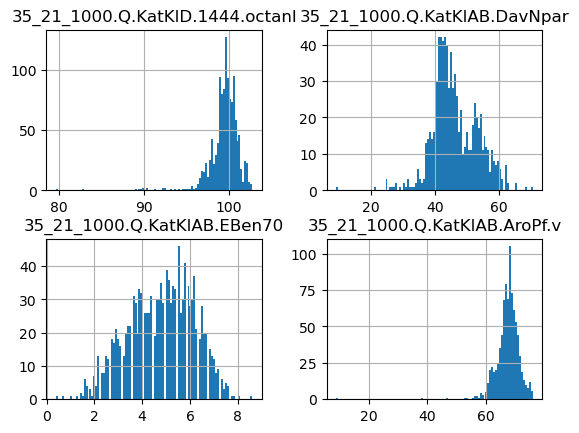

In [10]:
soft_data.hist(bins=100)

In [11]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 1)

print(type(device), device)

<class 'torch.device'> cuda:1


**Обучение моделей**


In [12]:
def trainCV(X, y, R_class=None, R_params=dict(), n_folds=5, seed=42, train_size_in_folds=3,\
            tables_path=None, splitter=MyTimeSeriesSplitter(), y_scaler=None, R_opt=None, \
            R_opt_params=None, batch_size=4, R_loss=None, epoches=10, **kwargs):
    """
    Cross-validation with gived schema.
    
    Args:
        X (np.array or torch.tensor) : x data
        y (np.array or torch.tensor) : target data
        R_class : Regressor class
        R_params (dict) : parameters for instantiation Regressor
        n_folds (int) : number of folds
        seed (int) : random seed
        train_size_in_folds (int) : minimum number of folds in train
        tables_path (string) : where to save results table in each step of cross-validation
        splitter : object of Splitter class, schema to organize cross-validation
        ...
    Returns:
        losses (List[dict]) : list of losses for each step (for each mode)
        Rs : list of trained Regressor model
        results (List[pd.DataFrame]) : if tables_path is None, results from each step
    """
    X, y = [torch.tensor(tmp, dtype=torch.float32) for tmp in (X, y)]
    losses, Rs = [], []
    results = []
    for i, (train_inds, test_inds) in enumerate(splitter.split(X)):
        print("______________")
        global_seed(seed)
        R = R_class(**R_params).to(device)
        R_optim = R_opt(R.parameters(), **R_opt_params)
        early_stopper = EarlyStopper(patience=20, min_delta=0, start_from_epoch=10, path=f"baseline_results/model_{SOFT_SENSOR_INDEX}")


        train_x, train_y, test_x, test_y = X[train_inds], y[train_inds], X[test_inds], y[test_inds]
        train_inds, valid_inds = train_test_split(train_inds, test_size=0.2, shuffle=False)
        train_x, valid_x, train_y, valid_y = X[train_inds], X[valid_inds], y[train_inds], y[valid_inds]
        print(f"train {train_x.shape}, valid {valid_x.shape}, test {test_x.shape}")
        #train

        losses_log = defaultdict(list)
        train_x, train_y, test_x, test_y = [tmp.to(device) for tmp in (train_x, train_y, test_x, test_y)]
        dataloader = DataLoader(np.arange(train_x.shape[0]), batch_size=batch_size, shuffle=True)
        for epoch in range(epoches):
            R_run_loss = 0
            R.train()
            for ids in dataloader:
                data_x, data_y = train_x[ids], train_y[ids]
                R_run_loss += R.train_(data_x, data_y, R_loss, R_optim)   
            losses_log['train'].append(R_run_loss / len(dataloader))

            #validation
            R.eval()
            with torch.no_grad():
                loss_R = R.eval_(test_x, test_y, R_loss)
                losses_log['valid'].append(loss_R)
            
            if epoch % 10 == 0:
                print(f"EPOCH : {epoch}| Train loss: {losses_log['train'][-1]} | Valid loss {losses_log['valid'][-1]}")
            if early_stopper.early_stop(losses_log['valid'][-1], R):
                best_epoch = early_stopper.min_loss_epoch_number
                print(f"Early stopping, epochs {epoch}, best epoch {best_epoch}: RMSE = {losses_log['valid'][best_epoch - 1]}")
                R = early_stopper.restore_model(R)
                break
        
        losses.append(losses_log)
        Rs.append(R)
        results.append(write_table(R, X, y, SOFT_SENSOR_INDEX, folder="baseline_results", mask_train=train_inds, mask_valid=valid_inds, mask_test=test_inds, \
                        num_fold=i, y_scaler=y_scaler, path=tables_path))
    if tables_path is None:
        return losses, Rs, results
    else:
        return losses, Rs


In [13]:
dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], K=K, diff=False, periods=PERIODS_FILE)
dataset_x, dataset_y, y_scaler = dataset.window_view(W=W, scale_target=True)


window_view: (1035, 5, 57) (1035,)


In [14]:
y_scaler.mean, y_scaler.std

(4.574975845410628, 1.252376243568682)

In [15]:
%%time
R_params = {'input_size':dataset_x.shape[-1], 'hidden_size':100, 'n_layers':2}
R_class = gan_model.LSTM_Regressor
R_loss = MSELoss()
R_opt = torch.optim.Adam
R_opt_params = {'lr':1e-4}

params = {'train_size_in_folds':3, 'n_folds':6, 'epoches':100, 'batch_size':4, 'K':K, 'W':W, \
                 'R_params':R_params, "type_of_test":"fixed", 'name':"LSTM"}

params["splitter"] = TestFixedSplitter(n_splits=params['n_folds'] - 1, train_size_in_folds=params["train_size_in_folds"])

losses, model, results = trainCV(dataset_x, dataset_y, R_class=R_class, R_opt=R_opt, R_loss=R_loss,\
            y_scaler=y_scaler, tables_path=None, R_opt_params=R_opt_params, **params)
_ = pack_results(results, SOFT_SENSOR_INDEX, folder="baseline_results", **params, save_to_file=True)

863 172
______________


/home/grinenko/anaconda3/envs/anna/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


train torch.Size([137, 5, 57]), valid torch.Size([35, 5, 57]), test torch.Size([172, 5, 57])
EPOCH : 0| Train loss: 0.852135267002242 | Valid loss 1.0911694765090942
EPOCH : 10| Train loss: 0.18100890232516187 | Valid loss 0.5816138386726379
EPOCH : 20| Train loss: 0.12337381610912936 | Valid loss 0.3978571891784668
EPOCH : 30| Train loss: 0.10996010755853994 | Valid loss 0.38829243183135986
EPOCH : 40| Train loss: 0.08616038776401963 | Valid loss 0.4086013734340668
Early stopping, epochs 48, best epoch 28: RMSE = 0.3805873692035675
______________
train torch.Size([275, 5, 57]), valid torch.Size([69, 5, 57]), test torch.Size([172, 5, 57])
EPOCH : 0| Train loss: 0.8111180955733078 | Valid loss 1.0508699417114258
EPOCH : 10| Train loss: 0.19753599728363147 | Valid loss 0.41882458329200745
EPOCH : 20| Train loss: 0.15103438956851978 | Valid loss 0.3673132359981537
EPOCH : 30| Train loss: 0.1269819610144781 | Valid loss 0.3590167164802551
EPOCH : 40| Train loss: 0.10876820550259689 | Valid